# SciML M2, TP3 partie 1 (noté): Apprentissage d'EDO

On se propose d'utiliser les deux TP précédent pour faire un premier apprentissage 

### Exercice 1: apprentissage d'EDO (A partir du cours 3)

On considère le problème EDO suivant:

$$
\frac{d}{dt}\left(\begin{array}{l}
q(t)\\
p(t)\end{array}\right)=\mathcal{J}^{-1}\nabla_{q,p} H(q,p)
$$

avec $H(p,q)$ de votre choix

On se propose de comparer les approches d'apprentissage.

1) Générez $M$ trajectoires associées à différentes condition initiales avec un temps final <m>T</m> et d'acrt <m>\Delta t</m>
2) Générez un jeux de données les données de sorties correspondant à une estimation de la dérivée a un temps t et les données d'entrée correspondant
a la solution $(q(t),p(t))$
3) Ajouter un petit bruit Gaussien aux données de variance $\sigma^2$
4) effecuez un un apprentissage avec un réseau sans imposer la structure Hamiltonienne
5) effecuez un un apprentissage avec Sindy sans imposer la structure Hamiltonienne
6) Comparer les deux approches en faisant varier: $\sigma$, le nombre de données total (donnée par <m>M*N</m> et <m>N=frac{T}{\Delta t}</m>). Comparer aussi 
leur capacité d'extrapolation.

7) Bonus (point en plus): coder un apprentissage Hamiltonien

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import pysindy as ps



On prend 
$$
H(q,p) = 1/2(p^2+k*q^2)
$$

on as donc 
$$
\frac{d}{dt}\left(\begin{array}{l}
q(t)\\
p(t)\end{array}\right)=\mathcal{J}^{-1}\nabla_{q,p} H(q,p) \\

\frac{d}{dt}
\begin{pmatrix}
q(t) \\
p(t)
\end{pmatrix}
=
\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix}
\begin{pmatrix}
p \\
-kq
\end{pmatrix}
=
\begin{pmatrix}
p \\
-kq
\end{pmatrix}




$$

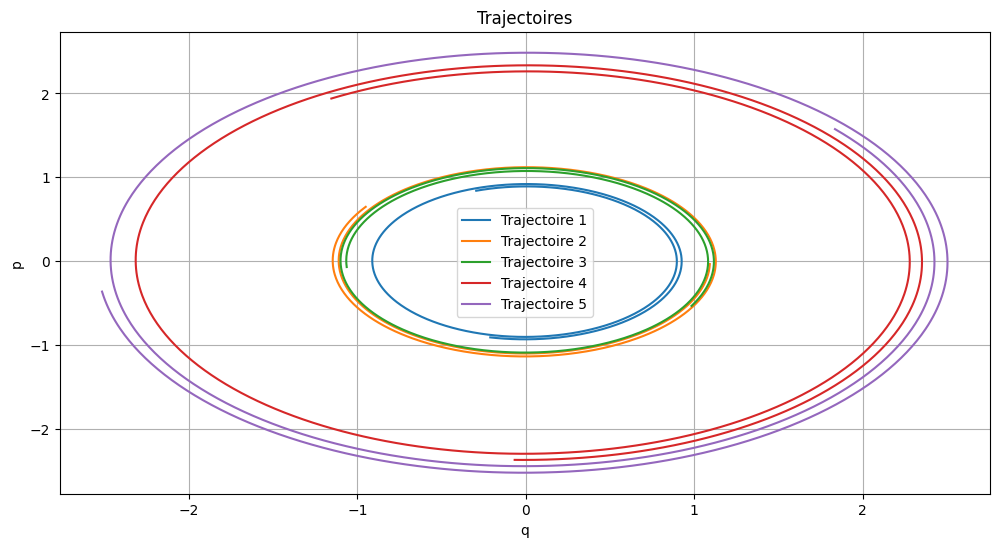

In [41]:

k = 1.0  
T = 10.0  
dt = 0.01  
M = 5  

def hocilateur_harmonique(q,p):
    return p**2/2 + 1/2 * k*q**2

def derivees(q, p):
    dq_dt = p 
    dp_dt = -k * q
    return dq_dt, dp_dt

trajectoires = []
for i in range(M):
    #Conditions initial aléatoires.
    q0 = np.random.uniform(-2, 2)
    p0 = np.random.uniform(-2, 2)
    
    q_values = [q0]
    p_values = [p0]

    q, p = q0, p0
    time_points = np.arange(0, T, dt)
    #Calculs des trajectoires sur 0:T
    for t in time_points[1:]: 
        dq_dt, dp_dt = derivees(q, p)
        q += dt * dq_dt
        p += dt * dp_dt
        q_values.append(q)
        p_values.append(p)
    
    trajectoires.append((time_points, q_values, p_values))

# Visualisation des trajectoires
plt.figure(figsize=(12, 6))
for i, (time_points, q_values, p_values) in enumerate(trajectoires):
    plt.plot(q_values, p_values, label=f"Trajectoire {i+1}")

plt.xlabel("q")
plt.ylabel("p")
plt.title("Trajectoires")
plt.legend()
plt.grid()
plt.show()


In [42]:
def generate_data(sigma,M):
    X = []  
    Y = [] 

    for _ in range(M):
        #bruit aleatoire 
        q0 = np.random.uniform(-2, 2)
        p0 = np.random.uniform(-2, 2)
        q, p = q0, p0
        time_points = np.arange(0, T, dt)
        for t in time_points:
            dq_dt, dp_dt = derivees(q, p)
            X.append([q + np.random.normal(0, sigma), p + np.random.normal(0, sigma)])
            Y.append([dq_dt + np.random.normal(0, sigma), dp_dt + np.random.normal(0, sigma)])
            q += dt * dq_dt
            p += dt * dp_dt

    X = np.array(X)
    Y = np.array(Y)
    return X,Y


X,Y = generate_data(0.1,5)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)  
])

#training du modele
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Erreur moyenne absolue sur le jeu de test : {test_mae}")
print(f"loss sur le jeu de test : {test_loss}")

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3788 - mae: 0.4144 - val_loss: 0.0236 - val_mae: 0.1225
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 0.0241 - mae: 0.1249 - val_loss: 0.0202 - val_mae: 0.1134
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - loss: 0.0215 - mae: 0.1181 - val_loss: 0.0196 - val_mae: 0.1113
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0205 - mae: 0.1143 - val_loss: 0.0203 - val_mae: 0.1138
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0210 - mae: 0.1160 - val_loss: 0.0207 - val_mae: 0.1143
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 0.0208 - mae: 0.1149 - val_loss: 0.0195 - val_mae: 0.1111
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 0.0204 - mae: 0.1148 - val_loss: 0.0199 - val_mae: 0.1126
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 0.0211 - mae: 0.1165 - val_loss: 0.0195 - val_mae: 0.1116
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


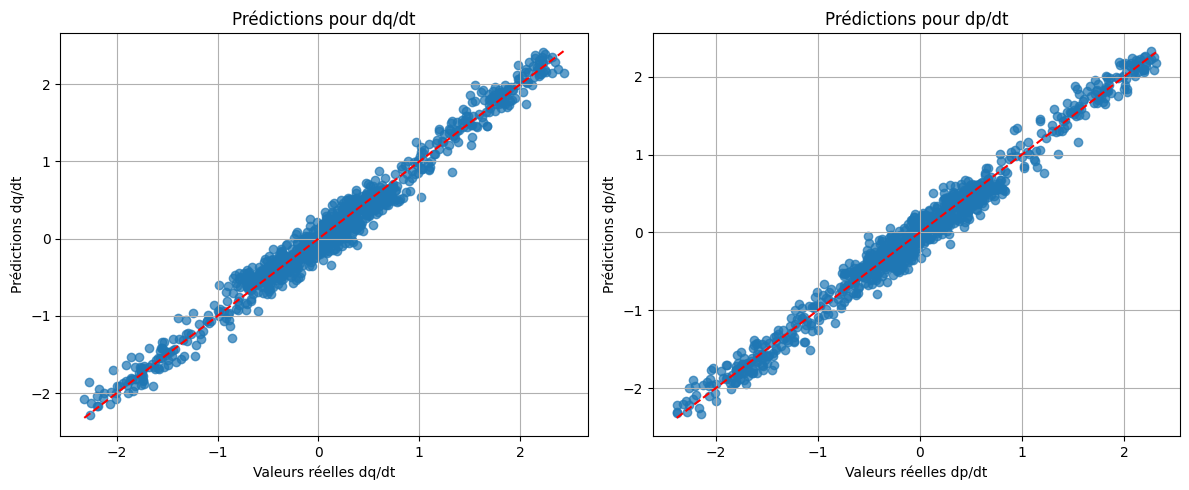

In [43]:
y_pred = model.predict(X_test)

# Visualisation des prédictions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred[:, 0], label='dq/dt', alpha=0.7)
plt.xlabel("Valeurs réelles dq/dt")
plt.ylabel("Prédictions dq/dt")
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], 'r--')
plt.title("Prédictions pour dq/dt")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred[:, 1], label='dp/dt', alpha=0.7)
plt.xlabel("Valeurs réelles dp/dt")
plt.ylabel("Prédictions dp/dt")
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], 'r--')
plt.title("Prédictions pour dp/dt")
plt.grid()

plt.tight_layout()
plt.show()

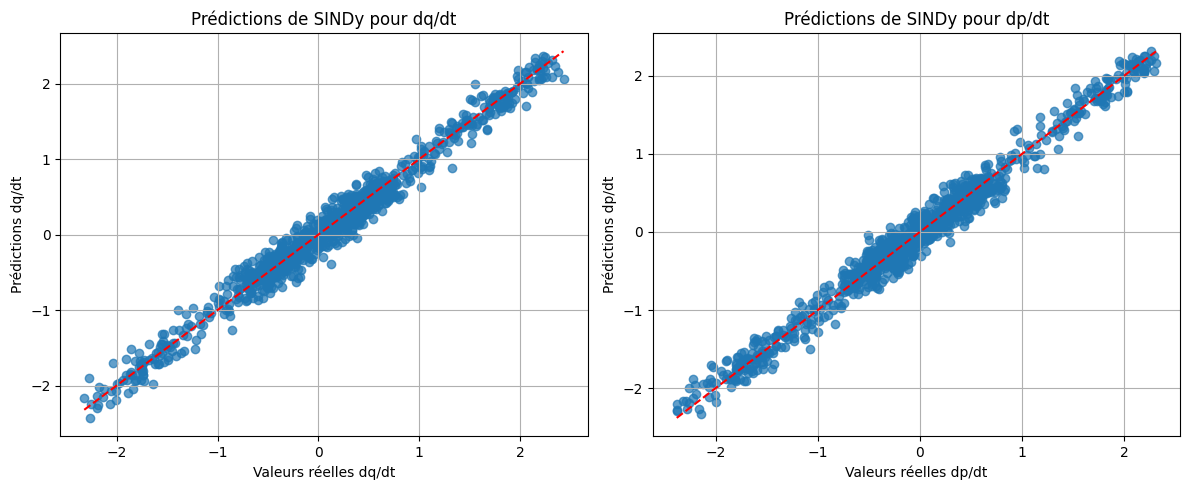

In [44]:

#training sindy
optimizer = ps.STLSQ(threshold=0.1)
feature_library = ps.PolynomialLibrary(degree=2)  
sindy_model = ps.SINDy(optimizer=optimizer, feature_library=feature_library)
sindy_model.fit(X_train, t=dt, x_dot=y_train)  
y_pred_sindy = sindy_model.predict(X_test)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test[:, 0], y_pred_sindy[:, 0], label='dq/dt', alpha=0.7)
plt.xlabel("Valeurs réelles dq/dt")
plt.ylabel("Prédictions dq/dt")
plt.plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], 'r--')
plt.title("Prédictions de SINDy pour dq/dt")
plt.grid()

plt.subplot(1, 2, 2)
plt.scatter(y_test[:, 1], y_pred_sindy[:, 1], label='dp/dt', alpha=0.7)
plt.xlabel("Valeurs réelles dp/dt")
plt.ylabel("Prédictions dp/dt")
plt.plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], 'r--')
plt.title("Prédictions de SINDy pour dp/dt")
plt.grid()

plt.tight_layout()
plt.show()

In [45]:
sigmas = [0.01, 0.1, 0.5, 1.0] 
Ms = [5, 10, 20 , 40]  

results = []

for sigma in sigmas:
    for M in Ms:
        X, y = generate_data(sigma, M)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #SINDY
        optimizer = ps.STLSQ(threshold=0.1)
        feature_library = ps.PolynomialLibrary(degree=2)  
        sindy_model = ps.SINDy(optimizer=optimizer, feature_library=feature_library)
        sindy_model.fit(X_train, t=dt, x_dot=y_train)  
        y_pred_sindy = sindy_model.predict(X_test)
        sindy_mae = np.mean(np.abs(y_test - y_pred_sindy))
      

        #tensorflow
       
        model = tf.keras.models.Sequential([tf.keras.layers.Dense(64, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2)  
        ])

        #training du modele
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

        y_pred_tensorflow = model.predict(X_test)
        tensorflow_mae = np.mean(np.abs(y_test - y_pred_tensorflow))

        results.append((sigma, M, float(sindy_mae), float(tensorflow_mae)))


        

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6106 - mae: 0.5846 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0014 - mae: 0.0299 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 9.6177e-04 - mae: 0.0245 - val_loss: 8.4098e-04 - val_mae: 0.0226
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - loss: 7.3337e-04 - mae: 0.0213 - val_loss: 6.2556e-04 - val_mae: 0.0199
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - loss: 5.6687e-04 - mae: 0.0189 - val_loss: 4.6962e-04 - val_mae: 0.0172
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - loss: 4.1481e-04 - mae: 0.0161 - val_loss: 3.7007e-04 - val_mae: 0.0152
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - loss: 3.4176e-04 - mae: 0.0146 - val_loss: 3.1894e-04 - val_mae: 0.0142
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 2.7601e-04 - mae: 0.0132 - val_loss: 2.7848e-04 - val_mae: 0

In [46]:
print("Comparaison (sigma, M,SINDy mae,Tensorflow mae):")
for result in results:
    print(result)

Comparaison (sigma, M,SINDy mae,Tensorflow mae):
(0.01, 5, 0.011142343972350015, 0.013550778389831241)
(0.01, 10, 0.011304218099921007, 0.013786541342367063)
(0.01, 20, 0.01112727733585879, 0.013371244858549782)
(0.01, 40, 0.011217330818806558, 0.012370599575420319)
(0.1, 5, 0.1150151673396125, 0.11928780584071928)
(0.1, 10, 0.11454958747865016, 0.11637556139293079)
(0.1, 20, 0.11197977705735658, 0.11428032869029825)
(0.1, 40, 0.11305405868825942, 0.11365720669751421)
(0.5, 5, 0.5510371331212701, 0.5330570024088275)
(0.5, 10, 0.5502377996174281, 0.5356735201175797)
(0.5, 20, 0.5359681530169887, 0.5306581967246959)
(0.5, 40, 0.5398283581385456, 0.5386244149960602)
(1.0, 5, 1.0205229681858599, 1.0238368931353128)
(1.0, 10, 1.021367770583055, 1.0174614214941382)
(1.0, 20, 1.0392385747715416, 1.02317149598552)
(1.0, 40, 0.9845602635910086, 0.9836798207350961)


Ici on observe que la mae de Sindy et Tensorflow augmente par rapport au bruit que l'on rajoute sur les données d'entrées.


### Exercice 2: Apprentissage de flot (A partir du cours 4)

1) Reprennez la même EDO et effectuer un apprentissage de flot discret.
2) Effecutez un apprentissage de flot symplectique (SymPnet)
3) Comparer les deux et comparer aux apprentissages de la partie 1 selon les critères de (6). Regardez aussi les différences en temps long.

4) Bonus: Effectuer un apprentissage avec rollout du flot discret et comparer.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

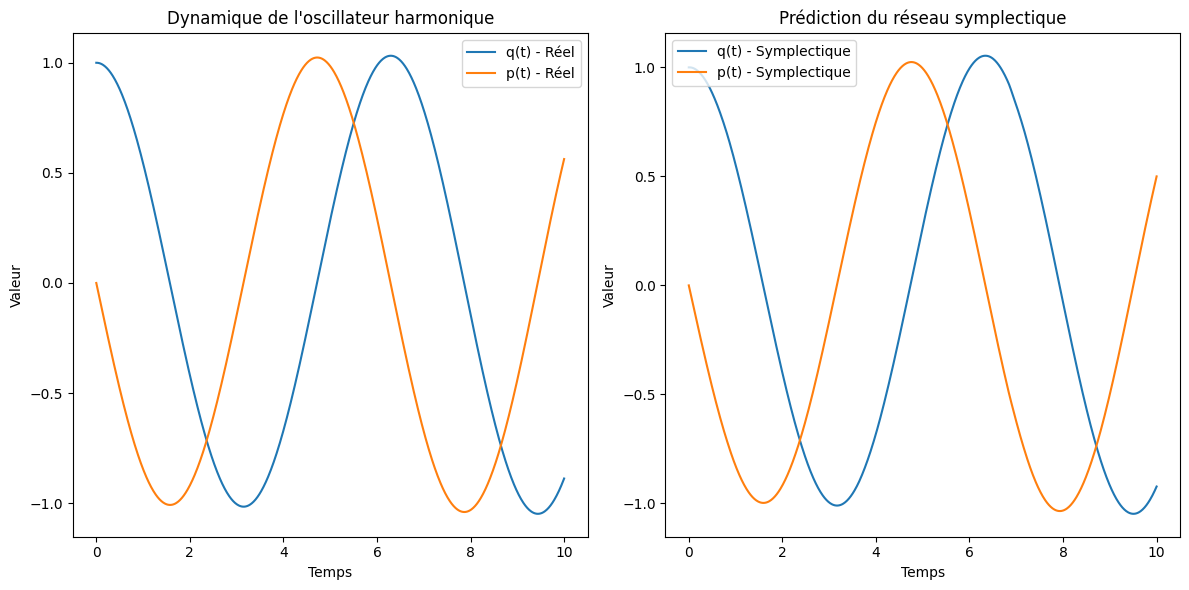

In [47]:


N = int(T / dt)  
q0 = 1.0
p0 = 0.0
q = np.zeros(N)
p = np.zeros(N)
q[0] = q0
p[0] = p0

#apprentissage en flot discret : 
for i in range(1, N):
    q[i] = q[i-1] + dt*p[i-1]
    p[i] = p[i-1] - k*dt*q[i-1]

#On part de la SYmplectic pour avoir le SympNet de tensorflow 
class SymplecticNN(tf.keras.Model):
    def __init__(self):
        super(SymplecticNN, self).__init__()
        self.hidden_layer = layers.Dense(10, activation='relu')
        self.output_layer = layers.Dense(2)  

    def call(self, inputs):
        h = self.hidden_layer(inputs)
        return self.output_layer(h)


#training
model = SymplecticNN()
model.compile(optimizer='adam', loss='mse')
inputs = np.array([[q[i], p[i]] for i in range(N-1)])  # Données d'entrée
targets = np.array([[q[i+1], p[i+1]] for i in range(N-1)])  # Données de sortie
model.fit(inputs, targets, epochs=10000, verbose=0)

#test
q_symplectic = np.zeros(N)
p_symplectic = np.zeros(N)
q_symplectic[0] = q0
p_symplectic[0] = p0

for i in range(1, N):
    input_data = np.array([[q_symplectic[i-1], p_symplectic[i-1]]])
    output = model.predict(input_data)
    q_symplectic[i], p_symplectic[i] = output[0]

# Graphique des résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, T, N), q, label='q(t) - flot discret')
plt.plot(np.linspace(0, T, N), p, label='p(t) - flot discret')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.linspace(0, T, N), q_symplectic, label='q(t) - Symplectique')
plt.plot(np.linspace(0, T, N), p_symplectic, label='p(t) - Symplectique')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()

plt.tight_layout()
plt.show()